In [377]:
from simtk.openmm.app import*
from openforcefield.utils import*

In [378]:
from simtk.openmm.app import PDBFile
from openforcefield.utils import get_data_file_path

In [379]:
ls

Acetylacetone_04_July.py        Acetylacetone_mdtraj.ipynb
Acetylacetone_10_frames.ipynb   Acetylacetone.pdb
Acetylacetone_200+frames.ipynb  CC minimized.png
Acetylacetone Exp-Copy1.ipynb   README.md
Acetylacetone Exp-Copy.ipynb


In [380]:
import os

pdb_file_path = os.path.join('Acetylacetone.pdb')
pdbfile = PDBFile(pdb_file_path)

# I got the pdb file from
# https://www.ebi.ac.uk/pdbe-srv/pdbechem/chemicalCompound/show/P2D
# renamed it, then I manually moved it to the data directory of openforcefield.

print(pdbfile)

In [381]:
from openforcefield.topology import Molecule
acetylacetone = Molecule.from_smiles('O=C(C)CC(=O)C')
print(acetylacetone)

# I got the SMILES-code from:
# https://en.wikipedia.org/wiki/Acetylacetone

Molecule with name '' and SMILES '[H][C]([H])([H])[C](=[O])[C]([H])([H])[C](=[O])[C]([H])([H])[H]'


In [382]:
print (pdb_file_path)

Acetylacetone.pdb


In [383]:
from openforcefield.topology import *
from openforcefield.typing.engines.smirnoff import ForceField

omm_topology =  pdbfile.topology
off_topology = Topology.from_openmm(omm_topology, unique_molecules=[acetylacetone])

forcefield = ForceField('openff-1.0.0.offxml')

system = forcefield.create_openmm_system(off_topology)


In [384]:
from simtk import *

# Langevin Dynamics:
time_step = 2*unit.femtoseconds
temperature = 300*unit.kelvin
friction = 1/unit.picosecond # collision rate
integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

# Lenghth of simulation:
num_steps = 1000

trj_freq = 1 # number of steps per written trajectory frame
data_freq = 1 #number of steps per fritten simulation statistics

# Set up OpenMM simulation:
simulation = openmm.app.Simulation (omm_topology, system, integrator)

# initial positions:
positions = pdbfile.getPositions()
simulation.context.setPositions(positions)

# Randomize the velocities from a Boltzmann distribution at a given temperature.
simulation.context.setVelocitiesToTemperature(temperature)

# MINIMIZE ENERGY: I deleted this line to get the non-minimized values:
simulation.minimizeEnergy()
minimized_coords = simulation.context.getState(getPositions=True).getPositions()
minimized_forces = simulation.context.getState(getForces=True).getForces()

# Configure information in output files:
pdb_reporter = openmm.app.PDBReporter('trajectory.pdb', trj_freq)
state_data_reporter = openmm.app.StateDataReporter ('data.csv', data_freq, step=True, potentialEnergy=True, temperature=True, density=True)
simulation.reporters.append (pdb_reporter)
simulation.reporters.append (state_data_reporter)
DCDReporter = openmm.app.DCDReporter ('traj.dcd', reportInterval=1)
simulation.reporters.append (DCDReporter)

In [385]:
help (openmm.app.DCDReporter)

Help on class DCDReporter in module simtk.openmm.app.dcdreporter:

class DCDReporter(builtins.object)
 |  DCDReporter(file, reportInterval, append=False, enforcePeriodicBox=None)
 |  
 |  DCDReporter outputs a series of frames from a Simulation to a DCD file.
 |  
 |  To use it, create a DCDReporter, then add it to the Simulation's list of reporters.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, file, reportInterval, append=False, enforcePeriodicBox=None)
 |      Create a DCDReporter.
 |      
 |      Parameters
 |      ----------
 |      file : string
 |          The file to write to
 |      reportInterval : int
 |          The interval (in time steps) at which to write frames
 |      append : bool=False
 |          If True, open an existing DCD file to append to.  If False, create a new file.
 |      enforcePeriodicBox: bool
 |          Specifies whether particle positions should be translated so the center of every molecule
 |          lies in the sam

In [386]:
import time

print("Starting simulation")
start = time.process_time()

# Run the simulation
simulation.step(num_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Hurra!")

Starting simulation
Elapsed time 0.75 seconds
Hurra!


In [387]:
ff_applied_parameters = forcefield.label_molecules(off_topology)[0]
ff_values=[]
ff_valuefile = open ('ff_valuefile.txt', 'w+')

for atoms, bonds in ff_applied_parameters['Bonds'].items():
    ff_valuefile.write (F'{atoms},{bonds}')
    ff_valuefile.write ('\n')
    
ff_valuefile.close()

In [388]:
import numpy

ff_valuefile = open ('ff_valuefile.txt', 'r')

ff_valuetab = numpy.genfromtxt(fname=ff_valuefile, dtype='unicode', delimiter='Lenght')

ff_valuefile.close


<function TextIOWrapper.close()>

import numpy
import os

mincoorfile = os.path.join('trajectory.pdb')

mincoor = numpy.genfromtxt(fname=mincoorfile, skip_header=2, skip_footer=2, dtype='unicode')

print (mincoor)

xyz_data = mincoor[:,6:9]
xyz_data = xyz_data.astype(numpy.float)
print (xyz_data)

xa = xyz_data[man_atom_a,0]
xb = xyz_data[man_atom_b,0]
ya = xyz_data[man_atom_a,1]
yb = xyz_data[man_atom_b,1]
za = xyz_data[man_atom_a,2]
zb = xyz_data[man_atom_b,2]

bondlength_min=numpy.sqrt(((xa-xb)**2)+((ya-yb)**2)+((za-zb)**2))

print (bondlength_min)    

In [389]:
import mdtraj as md

t = md.load('traj.dcd', top='Acetylacetone.pdb')
print(t)

<mdtraj.Trajectory with 1000 frames, 15 atoms, 1 residues, without unitcells>


In [390]:
from __future__ import print_function
print('How many atoms? %s' %t.n_atoms)

How many atoms? 15


In [391]:
frame_idx = 0
atom_idx = 9
print('Where is 9th Atom?')
print('x; %s\ty: %s\tz: %s' %tuple(t.xyz[frame_idx, atom_idx,:]))

Where is 9th Atom?
x; 0.31042835	y: -0.03777298	z: 0.09186311


In [392]:
t_topology=t.topology
print(t_topology)

for atom in t_topology.atoms:
    print (atom)

<mdtraj.Topology with 1 chains, 1 residues, 15 atoms, 14 bonds>
P2D1-C1
P2D1-C2
P2D1-C3
P2D1-C4
P2D1-C5
P2D1-O2
P2D1-O4
P2D1-H1
P2D1-H2
P2D1-H3
P2D1-H4
P2D1-H5
P2D1-H6
P2D1-H7
P2D1-H8


In [393]:
import numpy as np
COlist = numpy.array ([[1,5],[3,6]])
CClist = numpy.array ([[0,1], [1,2],[2,3], [3,4]])
C1Hlist = numpy.array ([[0,7], [0,8], [0,9]])
C3Hlist = numpy.array ([[2,10], [2,11]])
C5Hlist = numpy.array ([[4,12], [4,13], [4,14]])

import matplotlib.pyplot as plt

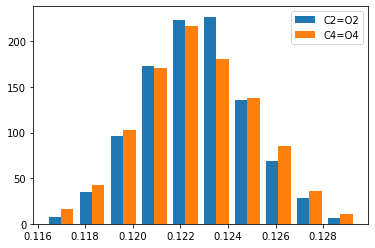

In [394]:
CO_distances=(md.compute_distances(t, COlist))

plt.figure()
#plt.xlabel('Bondlenght in nm')
#plt.ylabel('Number of Bonds')
#plt.title('C=O bonds lenght')
plt.hist(CO_distances, label=('C2=O2','C4=O4'))
plt.legend()
plt.show()

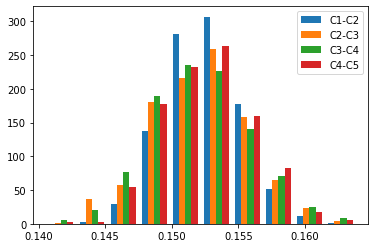

In [403]:
CC_distances = md.compute_distances(t, CClist)

plt.hist(CC_distances, label=('C1-C2','C2-C3', 'C3-C4', 'C4-C5'))
plt.legend()

plt.savefig('CC minimized.png')

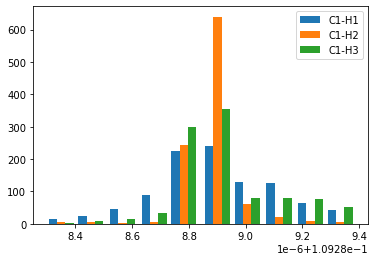

In [396]:
C1H_distances = md.compute_distances(t, C1Hlist)

figC1H = plt.hist(C1H_distances, label=('C1-H1','C1-H2', 'C1-H3'))
plt.legend()

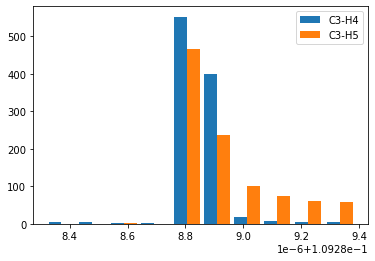

In [397]:
C3H_distances=md.compute_distances(t, C3Hlist)

figC3H = plt.hist(C3H_distances, label=('C3-H4','C3-H5'))
plt.legend()

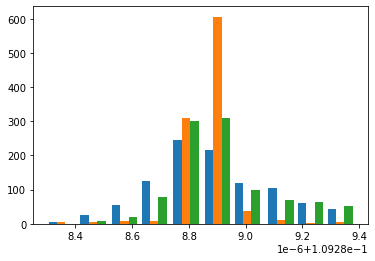

In [398]:
C5H_distances = md.compute_distances(t, C5Hlist)

figC5H = plt.hist(C5H_distances, label=('C5-H6','C5-H7', 'C5-H8'))